In [273]:
import numpy as np
np.random.seed(666666)

c:\Users\cloudcine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
c:\Users\cloudcine\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  7%|▋         | 35/500 [00:00<00:02, 159.48it/s]

Epoch [10/500] Train Loss: 0.029473  Val Loss: 0.060777
Epoch [20/500] Train Loss: 0.010384  Val Loss: 0.022776
Epoch [30/500] Train Loss: 0.003281  Val Loss: 0.003107
Epoch [40/500] Train Loss: 0.001575  Val Loss: 0.001871


 13%|█▎        | 67/500 [00:00<00:02, 151.36it/s]

Epoch [50/500] Train Loss: 0.001597  Val Loss: 0.000923
Epoch [60/500] Train Loss: 0.001498  Val Loss: 0.000941
Epoch [70/500] Train Loss: 0.001429  Val Loss: 0.000924

Early stopping at epoch 79 (best val loss = 0.000873)


 16%|█▌        | 78/500 [00:00<00:02, 153.01it/s]


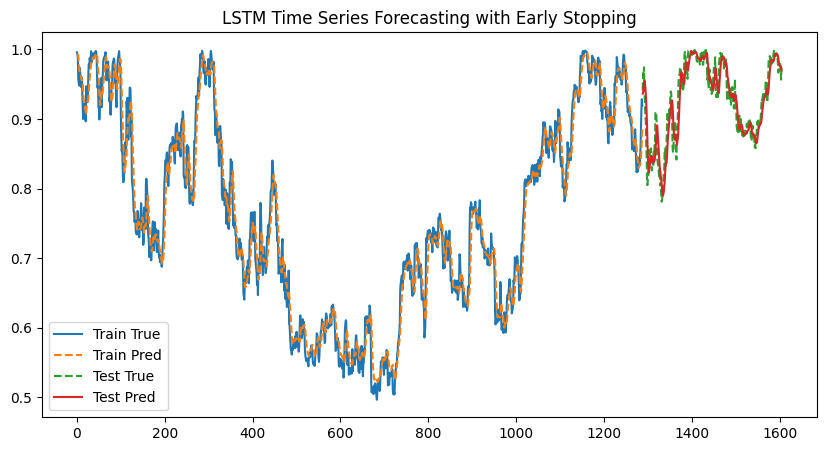

In [277]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Parameters:
window_size = 7
test_size = 0.2
val_ratio = 0.2
Lrate = 0.01
num_layers = 1
hidden_size = 64

# ======= Early Stopping 参数 =======
patience = 30       # 连续多少 epoch 无提升则停止
min_delta = 1e-8    # 最小改善幅度
epochs = 500        # 最大epoch数


df = pd.read_csv('./data/BTC_factors/addresses/BTC_1h_profit_relative.csv')
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
start_time = '2021-01-01 00:00:00'
df = df.sort_values('datetime')
df.set_index(df.columns[0], inplace=True)
df = df.resample('D').mean()    
df = df[start_time:]
values = df["profit_relative"].values.astype(float)
values =values.reshape(-1,1)
train_size = int(len(values) * (1-test_size))
train_data_raw = values[:train_size]
test_data_raw = values[train_size:]

# 2. scaler 只拟合训练集
scaler = MinMaxScaler()
train_data= scaler.fit_transform(train_data_raw)
test_data= scaler.transform(test_data_raw)

def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

X_train_full, y_train_full = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# 从训练集内部切出验证集（例如 20%）
val_size = int(len(X_train_full) * val_ratio)

X_val = torch.tensor(X_train_full[-val_size:], dtype=torch.float32)
y_val = torch.tensor(y_train_full[-val_size:], dtype=torch.float32)

X_train = torch.tensor(X_train_full[:-val_size], dtype=torch.float32)
y_train = torch.tensor(y_train_full[:-val_size], dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=hidden_size, num_layers=num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = LSTMModel()

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=Lrate)

# 当验证损失 5 个 epoch 未改善时，学习率 *= 0.5 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,
    min_lr=1e-5,
    verbose=True
) # Learning rate 动态调整

best_val_loss = float('inf')
patience_counter = 0

# ================= Training Loop =================
for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # ---- 计算验证集 Loss ----
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val).item()
        
    scheduler.step(val_loss)
    # ---- Early Stopping 判断 ----
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {loss.item():.6f}  Val Loss: {val_loss:.6f}")

    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1} (best val loss = {best_val_loss:.6f})")
        break


# ================= Prediction =================
model.eval()
with torch.no_grad():
    train_pred = model(torch.tensor(X_train_full, dtype=torch.float32))
    test_pred = model(X_test)

# 反归一化
train_pred = scaler.inverse_transform(train_pred.numpy())
y_train_true = scaler.inverse_transform(y_train_full)

test_pred = scaler.inverse_transform(test_pred.numpy())
y_test_true = scaler.inverse_transform(y_test.numpy())

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_train_true, label="Train True")
plt.plot(train_pred, label="Train Pred", linestyle="--")

plt.plot(range(len(y_train_true), len(y_train_true)+len(y_test_true)), y_test_true, linestyle="--", label="Test True")
plt.plot(range(len(y_train_true), len(y_train_true)+len(y_test_true)), test_pred, label="Test Pred")

plt.legend()
plt.title("LSTM Time Series Forecasting with Early Stopping")
plt.show()


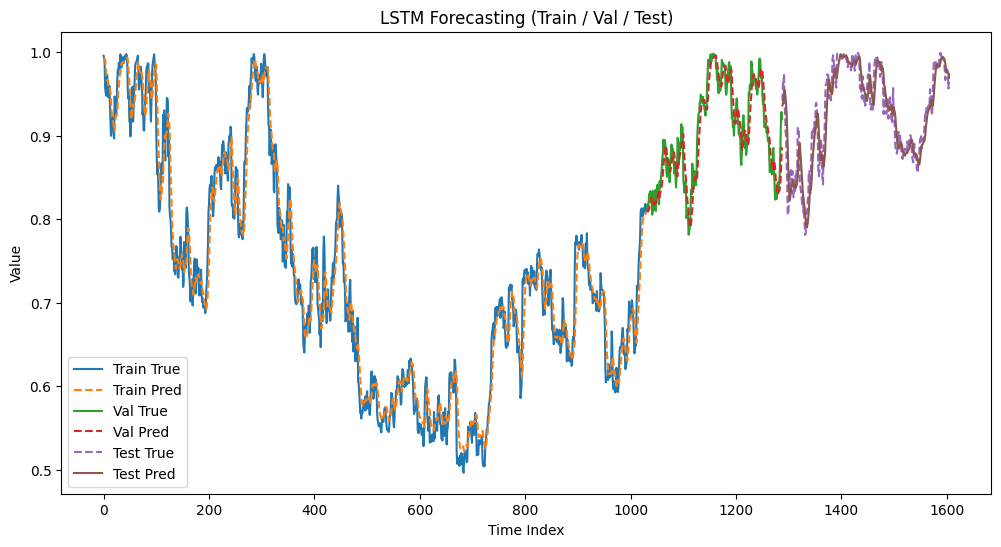

In [278]:
plt.figure(figsize=(12,6))

train_len = len(y_train_full) - len(y_val)   # 训练集长度
val_len = len(y_val)

# 1. Train True
plt.plot(range(train_len), 
         y_train_true[:train_len], 
         label="Train True")

# 1. Train Pred
plt.plot(range(train_len), 
         train_pred[:train_len], 
         linestyle="--", 
         label="Train Pred")

# 2. Val True
plt.plot(range(train_len, train_len + val_len),
         y_train_true[train_len:train_len + val_len],
         label="Val True")

# 2. Val Pred
plt.plot(range(train_len, train_len + val_len),
         train_pred[train_len:train_len + val_len],
         linestyle="--",
         label="Val Pred")

# 3. Test True
plt.plot(range(train_len + val_len,
               train_len + val_len + len(y_test_true)),
         y_test_true,
         linestyle="--",
         label="Test True")

# 3. Test Pred
plt.plot(range(train_len + val_len,
               train_len + val_len + len(test_pred)),
         test_pred,
         label="Test Pred")

plt.legend()
plt.title("LSTM Forecasting (Train / Val / Test)")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.show()


In [276]:
MSE = np.mean((test_pred-y_test_true)**2)
MAE = np.mean(np.abs(test_pred-y_test_true))
RMSE = np.sqrt(MSE)
MAPE = np.mean(np.abs((test_pred-y_test_true)/y_test_true))
MASE = np.mean(np.abs(y_test_true-test_pred))/np.mean(np.abs(np.array(y_test_true[1:])-np.array(y_test_true[:-1])))
result= [{'Method':' LSTM','RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'MASE':MASE}]
result_frame = pd.DataFrame(result)
result_frame

,Method,RMSE,MAE,MAPE,MASE
0,LSTM,0.013612,0.009883,0.010786,1.051177
